# Data100 Final Project - Predicting Championship Success
### Angela Chen, Vera Wang, Michelle Li

The goal of our project is to understand basketball teams that make it to the championships. What elements do these teams have in common? Do they have a specific strategy, a similar winning pattern, or the same types of players? Or, are these teams making it to the championships based on random factors/factors that cannot be quantitatively measured? We start off with cleaning our data to be more easily readable, and then we do some exploratory data analysis to better understand trends within the games. Next, we will analyze what factors (if any) are common between the teams that end up at the champsionships. Finally, we will try to use these factors to predict what teams will win the championships.

## Set up and Data Cleaning

In [7]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile
from pathlib import Path

Path.cwd()

PosixPath('/Users/verawang/Downloads/data100finalproject-master 2')

In [8]:
#Loading in dataset
standings = pd.read_csv("basketball/Standings.csv")
collegeset = pd.read_csv("basketball/college.csv")
box_score = pd.read_csv("basketball/Basketball-BoxScores.csv")
player_box_score = pd.read_csv("basketball/Basketball-PlayerBoxScore.csv")
team_box_score = pd.read_csv("basketball/Basketball-TeamBoxScores.csv")

In [9]:
#Cleaning college dataset 
college = collegeset.drop(columns = 'Unnamed: 0')
college = college.rename(columns = {'NBA_g_played': 'NBA_games', 'NCAA_fgpct' : 'NCAA_fg%'})
college = college[college['active_from'] > 2011]

In [10]:
#Cleaning player box score dataset 
player_box_score = player_box_score.rename(columns = {'playDispNm': 'name', 'playPos': 'pos', 'playHeight': 'height', 'playWeight': 'weight'})

## Part 1: Exploratory Data Analysis

Before diving into the different factors, we wanted to do some EDA to see if we could find any initial trends that really stood out to us (which could give us a "lead" on which factors to focus on). 

The first thing we wanted to do was to look at which teams had the most wins. Since the standings tables recorded the same amount of entries for each team, we can look at the raw numbers of wins instead of proportions.

In [11]:
wins = standings[standings['stkType'] == 'win']
byteam = wins.groupby('teamAbbr').size().sort_values(ascending = False)
tophalf = byteam.head(15)
tophalf

teamAbbr
GS     726
SA     702
HOU    637
LAC    635
OKC    622
TOR    598
MIA    563
IND    562
POR    555
BOS    541
CLE    537
MEM    526
CHI    516
ATL    508
UTA    505
dtype: int64

### Player Information

What do these teams have in common? Our initial instinct was to look at the player information, since it makes sense that good teams would have good players. We joined the tables with the players college information, their box scores, and their profession team standings. We then created visualizations.

We looked at which colleges were most prevalent amongst the players who were part of the top five teams.

In [15]:
playerinfo = pd.merge(player_box_score[['name', 'teamAbbr']], college[['name', 'college','NCAA_fg%', 'NBA_fg%']], how = 'inner', on = 'name').drop_duplicates('name')

Text(0.5, 1.0, 'Top Colleges Attended by Players in Top Teams')

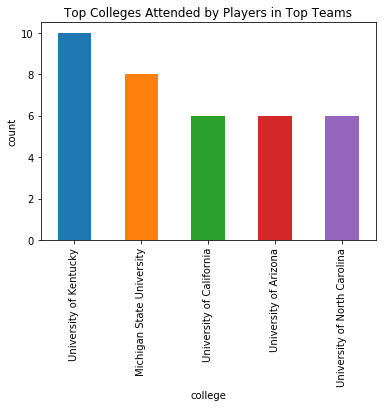

In [16]:
players_in_top_teams = playerinfo[playerinfo['teamAbbr'].isin(np.array(tophalf.index))]
topcolleges = players_in_top_teams.groupby('college').size().sort_values(ascending = False).head(5)
topcolleges.plot(kind = 'bar', x = 'college')
plt.ylabel('count')
plt.title('Top Colleges Attended by Players in Top Teams')

We also looked at the distribution of games played to see if successful teams necessarily had more veteran players, or if novice players also had a good chance of being on some of the top teams. We looked at NCAA games only, because we wannted to focus on how many games the players played before they were signed onto an NBA team. 

In [17]:
players_in_bottom_teams = playerinfo[~playerinfo['teamAbbr'].isin(np.array(tophalf.index))]
topteamsncaa = players_in_top_teams['NCAA_fg%']
bottomteamsncaa = players_in_bottom_teams['NCAA_fg%']

sns.distplot(topgames, hist = False, label = 'Top Half')
sns.distplot(bottomgames, hist = False, label = 'Bottom Half')
plt.xlabel('Fg%')
plt.ylabel('Distribution')
plt.title('Field Goal % Distribution (NCAA)')
plt.xlim(0, 1)

NameError: name 'topgames' is not defined

/Users/verawang/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/verawang/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/verawang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1)

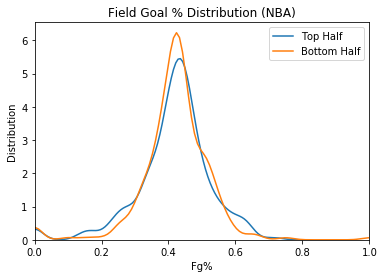

In [18]:
topteamsnba = players_in_top_teams['NBA_fg%']
bottomteamsnba = players_in_bottom_teams['NBA_fg%']

sns.distplot(topteamsnba, hist = False, label = 'Top Half')
sns.distplot(bottomteamsnba, hist = False, label = 'Bottom Half')
plt.xlabel('Fg%')
plt.ylabel('Distribution')
plt.title('Field Goal % Distribution (NBA)')
plt.xlim(0, 1)

### Game Information

Besides the players, the top teams probably have some type of strategy or gameplay they follow that helps them be successful. Although we aren't able to access the specific details of their game strategy, we can analyze information from the games themselves to see if there are any common patterns.

In [130]:
games1617 = box_score[box_score["gmDate"]>='2016-10-25']
games1617 = games1617[games1617["gmDate"]<='2017-04-12']
games1617 = games1617.groupby("teamAbbr").mean().reset_index()
df = wins[wins['stDate'] == '2017-04-12']
playoffs1617 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
games1617["playoff_teams"] = np.where(games1617['teamAbbr'].isin(playoffs1617), 1, 0)

teamPPS      0.550826
teamOrtg     0.554917
teamEDiff    0.707122
opptFG%      0.560538
opptPTS1     0.537117
opptEFG%     0.543521
opptFIC      0.536464
opptFIC40    0.542607
opptDrtg     0.554917
opptEDiff    0.707122
Name: playoff_teams, dtype: float64


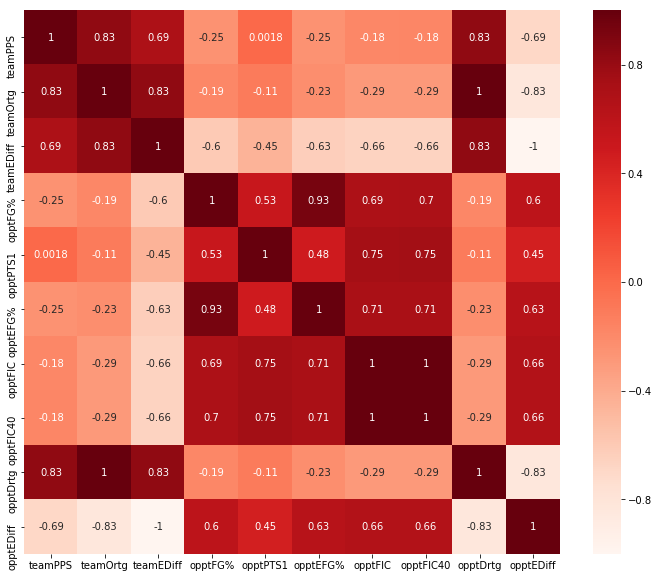

In [131]:
cor = games1617.corr()
output_var = abs(cor["playoff_teams"])

#Finding the most correlated features
relevant_features = output_var[output_var>=0.535].drop("playoff_teams")

print(relevant_features)

reldf = games1617[relevant_features.index]
plt.figure(figsize=(12,10))
sns.heatmap(reldf.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [132]:
# Get the teams that make playoff for each season
regular_season_end_dates = ['2013-04-17', '2014-04-16', '2015-04-15', '2016-04-13', '2017-04-12', '2018-04-11']
wins = standings[standings['stDate'].isin(regular_season_end_dates)]

games1213 = box_score[box_score["gmDate"]<='2013-04-17']
games1213 = games1213.groupby("teamAbbr").mean().reset_index()
df = wins[wins['stDate'] == '2013-04-17']
playoffs1213 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1213 = np.where(games1718['teamAbbr'].isin(playoffs1213), 1, 0)

games1314 = box_score[box_score["gmDate"]>'2013-04-17']
games1314 = games1314[games1314["gmDate"]<='2014-04-16']
games1314 = games1314.groupby("teamAbbr").mean().reset_index()
df = wins[wins['stDate'] == '2014-04-16']
playoffs1314 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1314 = np.where(games1314['teamAbbr'].isin(playoffs1314), 1, 0)

games1415 = box_score[box_score["gmDate"]>'2014-04-16']
games1415 = games1415[games1415["gmDate"]<='2015-04-15']
games1415 = games1415.groupby("teamAbbr").mean().reset_index()
df = wins[wins['stDate'] == '2015-04-15']
playoffs1415 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1415 = np.where(games1415['teamAbbr'].isin(playoffs1415), 1, 0)

games1516 = box_score[box_score["gmDate"]>'2015-04-15']
games1516 = games1516[games1516["gmDate"]<='2016-04-13']
games1516 = games1516.groupby("teamAbbr").mean().reset_index()
df = wins[wins['stDate'] == '2016-04-13']
playoffs1516 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1516 = np.where(games1516['teamAbbr'].isin(playoffs1516), 1, 0)

games1617 = box_score[box_score["gmDate"]>='2016-10-25']
games1617 = games1617[games1617["gmDate"]<='2017-04-12']
games1617 = games1617.groupby("teamAbbr").mean().reset_index()
df = wins[wins['stDate'] == '2017-04-12']
playoffs1617 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1617 = np.where(games1617['teamAbbr'].isin(playoffs1617), 1, 0)

games1718 = box_score[box_score["gmDate"]>='2017-10-17']
games1718 = games1718.groupby("teamAbbr").mean().reset_index()
df = wins[wins['stDate'] == '2018-04-11']
playoffs1718 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1718 = np.where(games1718['teamAbbr'].isin(playoffs1718), 1, 0)

## Part 2: What Factors Cause Teams to go to the Playoffs?

Now that we know a little bit more about what factors cause teams to be successful, we wanted to build a model that predicts what teams go to the championships. 

In [133]:
rel_cols = relevant_features.index
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver = 'lbfgs')
lr_model.fit(games1213[rel_cols], playoffs1213)
lr_model.fit(games1314[rel_cols], playoffs1314)
lr_model.fit(games1415[rel_cols], playoffs1415)
lr_model.fit(games1516[rel_cols], playoffs1516)
lr_model.fit(games1617[rel_cols], playoffs1617)

/Users/verawang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/verawang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/verawang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [134]:
Y = playoffs1718

Y_hat = lr_model.predict(games1617[rel_cols])
accuracy = np.mean(Y == Y_hat)
print("Prediction Accuracy:", accuracy)
Y_hat

Prediction Accuracy: 0.7


array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1])

In [135]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(games1213[rel_cols], playoffs1213)
dt_model.fit(games1314[rel_cols], playoffs1314)
dt_model.fit(games1415[rel_cols], playoffs1415)
dt_model.fit(games1516[rel_cols], playoffs1516)
dt_model.fit(games1617[rel_cols], playoffs1617)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [136]:
Y = playoffs1718

Y_hat = dt_model.predict(games1617[rel_cols])
accuracy = np.mean(Y == Y_hat)
print("Prediction Accuracy:", accuracy)
Y_hat

Prediction Accuracy: 0.7333333333333333


array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1])